<a href="https://colab.research.google.com/github/gauravksingh16/automated-multiple-eye-disease-detection/blob/main/MEDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf sample_data

In [ ]:
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

In [ ]:
!pip install lime
!pip install timm

In [ ]:
import numpy as np
import os
import cv2
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
from typing import List, Tuple
from PIL import ImageFile
from google.colab.patches import cv2_imshow
import csv
from torchvision import transforms
import torch
from skimage.segmentation import mark_boundaries
import lime
from lime import lime_image
import matplotlib.pyplot as plt
import timm
from functools import partial
import torch.nn as nn
import timm.models.vision_transformer
from timm.models.layers import trunc_normal_
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import torch.cuda.amp as amp
from torch.cuda.amp import GradScaler, autocast

In [ ]:
# !rm -rf /content/drive/MyDrive/EyeDataset/Preprocessed Images/
# !rm -rf /content/drive/MyDrive/EyeDataset/crop_info.csv

# **Image Preprocessing Steps**
**Reading and Writing Images:** These functions, imread and imwrite, provide convenient wrappers for reading and writing image files using OpenCV in Python. The imread function reads an image from a file path, decoding it with optional color specification. It ensures a valid image and converts it to RGB format if necessary. The imwrite function writes an image to a specified file path, handling color conversions and ensuring non-empty images. Both functions enhance ease of use for image file operations in Python.

---



**Folder Handling:** It helps in managing folders by creating them if they don't exist.


---



**Mask Generation:** The "get_mask_BZ" function processes an input image to create a binary mask. It converts a color image to grayscale, sets a threshold for binary masking, and refines the mask by filling holes and applying morphological operations. The final mask accurately delineates object boundaries and is suitable for image analysis or computer vision applications.


---


**Circle Detection:** These functions, _get_center_by_edge and _get_radius_by_mask_center, operate on binary masks of objects.

"_get_center_by_edge" calculates the center coordinates of an object based on the edge information in the mask. It identifies the vertical and horizontal centers by finding positions where the sum of pixel values is above 95% of the maximum, providing a list of coordinates.

"_get_radius_by_mask_center" determines the radius of an object given its binary mask and center coordinates. It employs morphological operations to enhance edges, calculates the Euclidean distance of edge points to the center, and derives the radius by identifying the most frequent distance. If no valid distances are found, a default radius of 0 is assigned. Both functions contribute to object analysis in image processing.

---



**Mask and Image Manipulation:** "The _get_circle_by_center_bbox" function generates a binary circular mask based on specified center coordinates, a bounding box, and radius. The "get_mask" function processes an input image to obtain a circular mask, along with information about the bounding box, center coordinates, and radius. The "mask_image" function applies a binary mask to an input image, setting non-masked pixels to zero. Additionally, the "remove_back_area" function removes the background area from an image based on either a specified bounding box or a custom border. The "supplemental_black_area" function adds supplemental black areas to an image to match a specified border. Overall, these functions provide essential tools for manipulating and analyzing images, particularly in the context of object detection and segmentation.

---

The "process_without_gb" function takes an input image, label, and lists for storing radius, center coordinates, and border information. It processes the input image by extracting a mask, removing background areas, and handling supplemental black areas. The function returns the processed image, border information, a mask converted to unsigned 8-bit integers, the processed label, and updated lists for radius and center coordinates.



In [ ]:
def imread(file_path: str, c: int = None) -> np.ndarray:
    if c is None:
        im = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), cv2.IMREAD_UNCHANGED)
    else:
        im = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), c)

    if im is None:
        raise Exception('Cannot read image')

    if im.ndim == 3 and im.shape[2] == 3:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

def imwrite(file_path: str, image: np.ndarray) -> None:
    if image is None or image.size == 0:
        print("Image is empty or None. Skipping image write.")
        return

    if image.ndim == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    elif image.dtype == np.bool_:
        image = (image * 255).astype(np.uint8)

    cv2.imwrite(file_path, image)

def fold_dir(folder: str) -> str:
    if not os.path.exists(folder):
        os.makedirs(folder)
    return folder

def get_mask_BZ(img: np.ndarray) -> np.ndarray:
    if img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = img
    threshold = np.mean(gray_img) / 3 - 5
    _, mask = cv2.threshold(gray_img, max(5, threshold), 1, cv2.THRESH_BINARY)

    nn_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), np.uint8)
    new_mask = (1 - mask).astype(np.uint8)
    _, new_mask, _, _ = cv2.floodFill(new_mask, nn_mask, (0, 0), (0), cv2.FLOODFILL_MASK_ONLY)
    _, new_mask, _, _ = cv2.floodFill(new_mask, nn_mask, (new_mask.shape[1] - 1, new_mask.shape[0] - 1), (0), cv2.FLOODFILL_MASK_ONLY)
    mask = mask + new_mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20,  20))
    mask = cv2.erode(mask, kernel)
    mask = cv2.dilate(mask, kernel)
    return mask

def _get_center_by_edge(mask: np.ndarray) -> List[int]:
    center = [0, 0]
    x = mask.sum(axis=1)
    center[0] = np.where(x > x.max() * 0.95)[0].mean()
    x = mask.sum(axis=0)
    center[1] = np.where(x > x.max() * 0.95)[0].mean()
    return center

def _get_radius_by_mask_center(mask: np.ndarray, center: List[int]) -> int:
    mask = mask.astype(np.uint8)
    ksize = max(mask.shape[1] // 400 * 2 + 1, 3)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
    mask = cv2.morphologyEx(mask, cv2.MORPH_GRADIENT, kernel)

    index = np.where(mask > 0)
    d_int = np.sqrt((index[0] - center[0]) ** 2 + (index[1] - center[1]) ** 2)
    b_count = np.bincount(np.ceil(d_int).astype(int))
    # Check if b_count is empty
    if not b_count.any():
        radius = 0  # Set a default radius
    else:
        radius = int(np.where(b_count > b_count.max() * 0.995)[0].max())
    return radius

    return radius

def _get_circle_by_center_bbox(shape: Tuple[int, int], center: List[int], bbox: Tuple[int, int, int, int], radius: int) -> np.ndarray:
    center_mask = np.zeros(shape=shape).astype('uint8')
    tmp_mask = np.zeros(shape=bbox[2:4])
    center_tmp = (int(center[0]), int(center[1]))
    center_mask = cv2.circle(center_mask, center_tmp[::-1], int(radius), (1), -1)
    return center_mask

def get_mask(img: np.ndarray) -> Tuple[np.ndarray, Tuple[int, int, int, int], List[int], int]:
    if img.ndim == 3:
        g_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif img.ndim == 2:
        g_img = img.copy()
    else:
        raise Exception('Image dimension is not 1 or 3')

    h, w = g_img.shape
    shape = g_img.shape[0:2]
    tg_img = cv2.normalize(g_img, None, 0, 255, cv2.NORM_MINMAX)
    tmp_mask = get_mask_BZ(tg_img)
    center = _get_center_by_edge(tmp_mask)
    radius = _get_radius_by_mask_center(tmp_mask, center)

    center = [center[0], center[1]]
    radius = int(radius)
    s_h = max(0, int(center[0] - radius))
    s_w = max(0, int(center[1] - radius))
    bbox = (s_h, s_w, min(h - s_h, 2 * radius), min(w - s_w, 2 * radius))
    tmp_mask = _get_circle_by_center_bbox(shape, center, bbox, radius)
    return tmp_mask, bbox, center, radius

def mask_image(img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    img[mask <= 0, ...] = 0
    return img

def remove_back_area(img: np.ndarray, bbox: Tuple[int, int, int, int] = None, border: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
    image = img
    if border is None:
        border = np.array((bbox[0], bbox[0] + bbox[2], bbox[1], bbox[1] + bbox[3], img.shape[0], img.shape[1]), dtype=int)
    image = image[border[0]:border[1], border[2]:border[3], ...]
    return image, border

def supplemental_black_area(img: np.ndarray, border: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray]:
    image = img
    if border is None:
        h, v = img.shape[0:2]
        max_l = max(h, v)
        if image.ndim > 2:
            image = np.zeros(shape=[max_l, max_l, img.shape[2]], dtype=int)
        else:
            image = np.zeros(shape=[max_l, max_l], dtype=int)
        border = (int(max_l / 2 - h / 2), int(max_l / 2 - h / 2) + h, int(max_l / 2 - v / 2), int(max_l / 2 - v / 2) + v, max_l)
    else:
        max_l = border[4]
        if image.ndim > 2:
            image = np.zeros(shape=[max_l, max_l, img.shape[2]], dtype=img.dtype)
        else:
            image = np.zeros(shape=[max_l, max_l], dtype=img.dtype)
    image[border[0]:border[1], border[2]:border[3], ...] = img
    return image, border

def process_without_gb(img: np.ndarray, label: np.ndarray, radius_list: List[int],
                       centre_list_w: List[int], centre_list_h: List[int]) -> Tuple[np.ndarray, List, np.ndarray, np.ndarray, List[int], List[int], List[int]]:
    borders = []
    mask, bbox, center, radius = get_mask(img)
    r_img = mask_image(img, mask)
    r_img, r_border = remove_back_area(r_img, bbox=bbox)
    mask, _ = remove_back_area(mask, border=r_border)
    label, _ = remove_back_area(label, bbox=bbox)
    borders.append(r_border)
    r_img, sup_border = supplemental_black_area(r_img)
    label, sup_border = supplemental_black_area(label)
    mask, _ = supplemental_black_area(mask, border=sup_border)
    borders.append(sup_border)

    radius_list.append(radius)
    centre_list_w.append(int(center[0]))
    centre_list_h.append(int(center[1]))

    return r_img, borders, (mask * 255).astype(np.uint8), label, radius_list, centre_list_w, centre_list_h

# **Run this code for example output:**

```
# Example usage:
img_path = "/content/drive/MyDrive/EyeDataset/Testing Images/1000_left.jpg"
label_path = "/content/drive/MyDrive/EyeDataset/Testing Images/1000_left.jpg"

img = imread(img_path)
label = imread(label_path)

radius_list = []
centre_list_w = []
centre_list_h = []

result_img, borders, mask, processed_label, radius_list, centre_list_w, centre_list_h = process_without_gb(img, label, radius_list, centre_list_w, centre_list_h)

# Display the input image
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Display the output image
cv2_imshow(result_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

print("Borders:")
print(borders)
print("Mask:")
print(mask)
print("Processed Label:")
print(processed_label)
print("Radii List:")
print(radius_list)
print("Center List W:")
print(centre_list_w)
print("Center List H:")
print(centre_list_h)
```



# **Save preprocessed Image and Metadata**

The script then iterates through each image in the training folder, processes the image using a function named process_without_gb, and extracts relevant information such as radius and center coordinates. The script saves the preprocessed image, appends details to lists, and prints debugging information. For each image, a new DataFrame is created, concatenated with the existing data, and the updated dataset is written to the CSV file. This script streamlines the preprocessing and organization of eye-related image data for subsequent analysis.


In [ ]:
# Set your training and preprocessed image folders
training_folder = "/content/drive/MyDrive/EyeDataset/Training Images/"
preprocessed_folder = "/content/drive/MyDrive/EyeDataset/Preprocessed Images/"
csv_info_file = "/content/drive/MyDrive/EyeDataset/stage2data.csv"

# Ensure the preprocessed folder exists
fold_dir(preprocessed_folder)

csv_columns = ["Name", "Radius", "Center_W", "Center_H", "Scale", "Scale Resolution"]

# Check if the CSV file already exists
if os.path.exists(csv_info_file):
    # Load the existing data from the CSV file
    data_df = pd.read_csv(csv_info_file)
else:
    # Initialize an empty DataFrame if the CSV file doesn't exist
    data_df = pd.DataFrame(columns=csv_columns)

# Iterate through each image in the training folder
for filename in os.listdir(training_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Update the file extensions if needed
        img_path = os.path.join(training_folder, filename)
        label_path = img_path  # Update this based on your label image paths

        img = imread(img_path)
        label = imread(label_path)

        # Initialize lists for each image
        radius_list = []
        centre_list_w = []
        centre_list_h = []
        name_list = []

        # Process the image
        result_img, borders, mask, processed_label, radius_list, centre_list_w, centre_list_h = process_without_gb(img, label, radius_list, centre_list_w, centre_list_h)

        # Additional processing for scale_list
        scale_list = [a * 2 / 912 for a in radius_list]

        # Save preprocessed image
        preprocessed_img_path = os.path.join(preprocessed_folder, filename)
        result_img = result_img.astype(np.uint8)
        imwrite(preprocessed_img_path, result_img)
        # Print a success message
        print("Image successfully written to:", preprocessed_img_path)

        # Modify the image path and append to name_list
        name_list.append(filename)


        # Print values for debugging
        print("name_list[0]:", name_list[0])
        print("radius_list[0]:", radius_list[0])
        print("centre_list_w[0]:", centre_list_w[0])
        print("centre_list_h[0]:", centre_list_h[0])
        print("scale_list[0]:", scale_list[0])
        print("scale_resolution[0]:", scale_list[0] * 1000)

        # Create a new DataFrame with the current image data
        new_data_df = pd.DataFrame({
            "Name": [name_list[0]],
            "Radius": [radius_list[0]],
            "Center_W": [centre_list_w[0]],
            "Center_H": [centre_list_h[0]],
            "Scale":[scale_list[0]],
            "Scale Resolution": [scale_list[0] * 1000]
        })

        # Concatenate the new DataFrame with the existing data_df
        data_df = pd.concat([data_df, new_data_df], ignore_index=True)

        # Write information to CSV file after each iteration
        data_df.to_csv(csv_info_file, index=False, encoding='utf-8')


# **Image Quality Grading**

The code loads a pre-trained ResNet model ([ EyeQ_Assesment ](https://colab.research.google.com/drive/1NQfqSr70qeoJQaT-wSaDZ3sEAp3RX4NW?usp=sharing)) for binary classification of eye images as good or bad quality. It processes image names from a CSV file, makes predictions, adds a 'quality' column to the DataFrame, and saves the updated data to the same CSV file. Error handling accounts for missing images or processing issues.

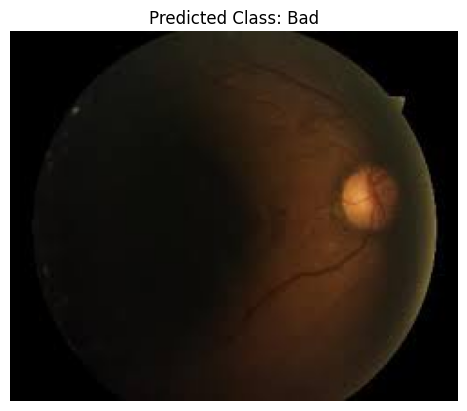

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define a transform to preprocess the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size based on your model's input size
    transforms.ToTensor(),
])

# Load the saved model
loaded_model = torch.load('/content/drive/MyDrive/EyeDataset/EyeQ_resnet_model.pth')
loaded_model.eval()

# Load and preprocess the test image
test_image_path = '/content/images (1).jpeg'  # Replace with the actual path to your test image
test_image = Image.open(test_image_path).convert('RGB')
input_tensor = transform(test_image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension as model expects batches

# If using GPU, move the input tensor to the GPU
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

# Perform inference
with torch.no_grad():
    output = loaded_model(input_batch)
    predictions = torch.sigmoid(output) > 0.5  # Use sigmoid with threshold 0.5 for binary predictions

# Map the predicted class index to the actual class label
class_labels = {0: 'Good', 1: 'Bad'}  # Update with your actual class labels

# Convert predictions to class labels
predicted_class = class_labels[predictions.item()]

# Display the test image and predicted class
plt.imshow(test_image)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


In [ ]:
# Define a transform to preprocess the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust size based on your model's input size
    transforms.ToTensor(),
])

# Load the saved model
loaded_model = torch.load('/content/drive/MyDrive/EyeDataset/EyeQ_resnet_model.pth')
loaded_model.eval()

In [ ]:
import torch
from torchsummary import summary

# Assuming loaded_model is your PyTorch model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = loaded_model.to(device)

# Print the model summary
summary(loaded_model, input_size=(3, 224, 224))  # Adjust input_size accordingly

In [ ]:
# Load the CSV file with image names
csv_path = '/content/drive/MyDrive/EyeDataset/stage2data.csv'
df = pd.read_csv(csv_path)

# Create a new column for predictions
df['quality'] = 0

# Loop through the rows and make predictions
for index, row in df.iterrows():
    image_path = '/content/drive/MyDrive/EyeDataset/Preprocessed Images/' + row['Name']

    try:
        # Check if the image file exists
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        image = Image.open(image_path).convert('RGB')
        image = transform(image)
        image = image.unsqueeze(0)  # Add batch dimension

        # Make predictions
        with torch.no_grad():
            output = loaded_model(image)
            prediction = torch.sigmoid(output) > 0.5
            df.at[index, 'quality'] = int(prediction.item())

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        continue

# Save the updated DataFrame with predictions
df.to_csv('/content/drive/MyDrive/EyeDataset/stage2data.csv', index=False)

# **Enhancing Bad Quality Images**

# **Defining Necessary Functions for RetFound**

In [ ]:
class VisionTransformer(timm.models.vision_transformer.VisionTransformer):
    """ Vision Transformer with support for global average pooling
    """
    def __init__(self, global_pool=False, **kwargs):
        super(VisionTransformer, self).__init__(**kwargs)

        self.global_pool = global_pool
        if self.global_pool:
            norm_layer = kwargs['norm_layer']
            embed_dim = kwargs['embed_dim']
            self.fc_norm = norm_layer(embed_dim)

            del self.norm  # remove the original norm

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        if self.global_pool:
            x = x[:, 1:, :].mean(dim=1)  # global pool without cls token
            outcome = self.fc_norm(x)
        else:
            x = self.norm(x)
            outcome = x[:, 0]

        return outcome


def vit_large_patch16(**kwargs):
    model = VisionTransformer(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def interpolate_pos_embed(model, checkpoint_model):
    if 'pos_embed' in checkpoint_model:
        pos_embed_checkpoint = checkpoint_model['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches
        # height (== width) for the checkpoint position embedding
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # height (== width) for the new position embedding
        new_size = int(num_patches ** 0.5)
        # class_token and dist_token are kept unchanged
        if orig_size != new_size:
            print("Position interpolate from %dx%d to %dx%d" % (orig_size, orig_size, new_size, new_size))
            extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
            # only the position tokens are interpolated
            pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
            pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
            pos_tokens = torch.nn.functional.interpolate(
                pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
            pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
            new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
            checkpoint_model['pos_embed'] = new_pos_embed

# **Defining Teacher and Student Model**

In [ ]:
def create_teacher_model():
    # Instantiate the ViT model
    model = vit_large_patch16(
        num_classes=8,
        drop_path_rate=0.2,
        global_pool=True,
    )
    checkpoint = torch.load('/content/drive/MyDrive/EyeDataset/RETFound_cfp_weights.pth', map_location='cpu')
    checkpoint_model = checkpoint['model']
    state_dict = model.state_dict()

    for k in ['head.weight', 'head.bias']:
        if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
            print(f"Removing key {k} from pretrained checkpoint")
            del checkpoint_model[k]

    interpolate_pos_embed(model, checkpoint_model)
    msg = model.load_state_dict(checkpoint_model, strict=False)
    assert set(msg.missing_keys) == {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}
    return model

# Define the ResNet model as the student
class ResNetStudent(nn.Module):
    def __init__(self, num_classes=8):
        super(ResNetStudent, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

# **Setting Up The Dataset**

In [ ]:
class EyeDiseaseDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 4])  # Right-Fundus column
        try:
            image = Image.open(img_name).convert('RGB')
        except FileNotFoundError:
            # Handle case where image is not found
            # print(f"Image '{img_name}' not found. Skipping...")
            return self.__getitem__((idx + 1) % len(self))  # Call __getitem__ recursively with the next index

        keywords = self.data.iloc[idx, 6]  # Assuming the right diagnostic keywords are in column 6
        labels = torch.tensor(eval(self.data.iloc[idx, -1]), dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, keywords, labels

In [ ]:
# Define data augmentation and transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),  # Rotate by up to 30 degrees
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly resize and crop
        transforms.RandomApply([transforms.RandomAffine(0, translate=(0.1, 0.1))], p=0.5),  # Randomly apply affine transformation
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [ ]:
def target_to_one_hot(targets):
    target_classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    one_hot_targets = []
    for target in targets:
        target_index = torch.argmax(target).item()
        one_hot_target = [0] * len(target_classes)
        one_hot_target[target_index] = 1
        one_hot_targets.append(one_hot_target)
    return torch.tensor(one_hot_targets)

def one_hot_to_label(one_hot_targets):
    labels = []
    for one_hot_target in one_hot_targets:
        label = np.argmax(one_hot_target)
        labels.append(label)
    return labels

In [ ]:
import pandas as pd
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split

# Load dataset
csv_file = "/content/drive/MyDrive/EyeDataset/full.csv"
root_dir = "/content/drive/MyDrive/EyeDataset/Preprocessed Images"
eye_dataset = EyeDiseaseDataset(csv_file=csv_file, root_dir=root_dir, transform=data_transforms['train'])

# Calculate class proportions dynamically
class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
for idx in range(len(eye_dataset)):
    _, _, labels = eye_dataset[idx]
    for i in range(len(labels)):
        class_counts[i] += labels[i].item()

total_samples = len(eye_dataset)
class_proportions = {key: count / total_samples for key, count in class_counts.items()}
print("Class Proportions:", class_proportions)

# Split dataset into training, validation, and test sets
train_size = 0.8
val_size = 0.1
test_size = 0.1

train_indices, val_test_indices = train_test_split(list(range(len(eye_dataset))), train_size=train_size, random_state=42)
val_indices, test_indices = train_test_split(val_test_indices, train_size=val_size / (val_size + test_size), random_state=42)

# Define data loaders for training, validation, and test sets
def create_data_loader(dataset, indices, batch_size):
    sampler = SubsetRandomSampler(indices)
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)

batch_size = 32
train_loader = create_data_loader(eye_dataset, train_indices, batch_size)
val_loader = create_data_loader(eye_dataset, val_indices, batch_size)
test_loader = create_data_loader(eye_dataset, test_indices, batch_size)


Image '/content/drive/MyDrive/EyeDataset/Preprocessed Images/2174_right.jpg' not found. Skipping...


TypeError: object of type 'NoneType' has no len()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# Load dataset
csv_file = "/content/drive/MyDrive/EyeDataset/full.csv"
root_dir = "/content/drive/MyDrive/EyeDataset/Preprocessed Images"
eye_dataset = EyeDiseaseDataset(csv_file=csv_file, root_dir=root_dir, transform=data_transforms['train'])

# Define ResNet model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)  # 8 classes

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define hyperparameters
num_epochs = 20
batch_size = 32

# Initialize cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over folds for cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(range(len(eye_dataset)), eye_dataset.data['target'])):
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(eye_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(eye_dataset, batch_size=batch_size, sampler=val_sampler)

    # Define scheduler for learning rate adjustment
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for images, keywords, targets in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validate the model
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for images, keywords, targets in val_loader:
                outputs = model(images)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        # Convert one-hot encoded targets back to labels
        val_labels = one_hot_to_label(val_targets)
        val_preds_labels = one_hot_to_label(val_preds)

        # Calculate accuracy using label-encoded targets and predictions
        val_accuracy = accuracy_score(val_labels, val_preds_labels)

        # Update learning rate
        scheduler.step(val_loss)

        print(f'Fold [{fold+1}/{skf.n_splits}], Epoch [{epoch+1}/{num_epochs}], '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

# Evaluate on test set
test_loss = 0.0
test_preds = []
test_targets = []
model.eval()
with torch.no_grad():
    for images, keywords, targets in test_loader:
        outputs = model(images)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_accuracy = accuracy_score(test_targets, test_preds)
test_precision = precision_score(test_targets, test_preds, average='macro')
test_recall = recall_score(test_targets, test_preds, average='macro')
test_f1 = f1_score(test_targets, test_preds, average='macro')
test_conf_matrix = confusion_matrix(test_targets, test_preds)

print(f'Test Loss: {test_loss:.4f}, '
      f'Test Accuracy: {test_accuracy:.4f}, '
      f'Test Precision: {test_precision:.4f}, '
      f'Test Recall: {test_recall:.4f}, '
      f'Test F1-score: {test_f1:.4f}')

# Define the class labels based on your target classes
classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Plotting the confusion matrix for the test set as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Test Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/20: 100%|██████████| 160/160 [28:46<00:00, 10.79s/it]


Fold [1/5], Epoch [1/20], Validation Loss: 0.2779, Validation Accuracy: 0.4504


Epoch 2/20: 100%|██████████| 160/160 [28:04<00:00, 10.53s/it]


Fold [1/5], Epoch [2/20], Validation Loss: 0.2768, Validation Accuracy: 0.4504


Epoch 3/20: 100%|██████████| 160/160 [27:30<00:00, 10.31s/it]


Fold [1/5], Epoch [3/20], Validation Loss: 0.2511, Validation Accuracy: 0.4504


Epoch 4/20: 100%|██████████| 160/160 [27:56<00:00, 10.48s/it]


KeyboardInterrupt: 

In [ ]:
# Instantiate the teacher model
teacher_model = create_teacher_model()

# Instantiate the ResNet student model
student_model = ResNetStudent(num_classes=8)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(student_model.parameters(), lr=0.001)

# Train the student model
num_epochs = 30
temperature = 3  # Temperature parameter for distillation

# Define distillation loss function
def distillation_loss(outputs_student, outputs_teacher, temperature=3):
    soft_targets = nn.functional.softmax(outputs_teacher / temperature, dim=1)
    return nn.KLDivLoss()(nn.functional.log_softmax(outputs_student / temperature, dim=1), soft_targets)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **Training and Testing Loop**

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the image
image_path = "/content/drive/MyDrive/EyeDataset/Preprocessed Images/1005_left.jpg"  # Replace with the path to your image file
image = Image.open(image_path)

# Define preprocessing transforms
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to match the input size expected by the teacher model
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

# Apply the preprocessing transforms to the image
input_tensor = preprocess(image)
input_tensor = input_tensor.unsqueeze(0)  # Add a batch dimension as the teacher model expects a batch of images

# Print the shape of the input tensor for debugging
print("Input tensor shape:", input_tensor.shape)

# Pass the input tensor through the teacher model
with torch.no_grad():  # No need to compute gradients
    teacher_model.eval()  # Set teacher model to evaluation mode
    outputs_teacher = teacher_model(input_tensor)

# Now you can print or analyze the outputs
print(outputs_teacher)

Input tensor shape: torch.Size([1, 3, 224, 224])


RuntimeError: Given normalized_shape=[1024], expected input with shape [*, 1024], but got input of size[1]

In [ ]:
for epoch in range(num_epochs):
    print(f'Starting epoch {epoch + 1}/{num_epochs}')
    student_model.train()
    teacher_model.eval()
    running_loss = 0.0
    for i, (images, _, targets) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        outputs_student = student_model(images)
        with torch.no_grad():  # No need for gradients for teacher model
                outputs_teacher = teacher_model(images)


        # Calculate classification loss
        loss_cls = criterion(outputs_student, targets)

        # Calculate distillation loss
        loss_distil = distillation_loss(outputs_student, outputs_teacher, temperature)

        # Combine both losses
        loss = loss_cls + loss_distil

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    student_model.eval()
    val_loss = 0.0
    val_preds = []
    val_targets = []
    with torch.no_grad():
        for images, _, targets in val_loader:
            outputs = student_model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_targets.extend(targets.cpu().numpy())
    val_loss /= len(val_loader.dataset)
    val_accuracy = accuracy_score(val_targets, val_preds)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {epoch_loss:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

# Evaluate the student model on the test set
test_loss = 0.0
test_preds = []
test_targets = []
student_model.eval()
with torch.no_grad():
    for images, _, targets in tqdm(test_loader):
        outputs = student_model(images)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_targets.extend(targets.cpu().numpy())

test_loss /= len(test_loader.dataset)
test_accuracy = accuracy_score(test_targets, test_preds)
test_precision = precision_score(test_targets, test_preds, average='macro')
test_recall = recall_score(test_targets, test_preds, average='macro')
test_f1 = f1_score(test_targets, test_preds, average='macro')
test_conf_matrix = confusion_matrix(test_targets, test_preds)

print(f'Test Loss: {test_loss:.4f}, '
      f'Test Accuracy: {test_accuracy:.4f}, '
      f'Test Precision: {test_precision:.4f}, '
      f'Test Recall: {test_recall:.4f}, '
      f'Test F1-score: {test_f1:.4f}')

# Define the class labels based on your target classes
classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# Plotting the confusion matrix for the test set as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Test Confusion Matrix')
plt.show()

In [ ]:
import pandas as pd
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import models
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim

# Load dataset and calculate class proportions
csv_file = "/content/drive/MyDrive/EyeDataset/full.csv"
root_dir = "/content/drive/MyDrive/EyeDataset/Preprocessed Images"
eye_dataset = EyeDiseaseDataset(csv_file=csv_file, root_dir=root_dir, transform=data_transforms['train'])

# Calculate class proportions dynamically
class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}
for idx in range(len(eye_dataset)):
    _, _, labels = eye_dataset[idx]
    for i in range(len(labels)):
        class_counts[i] += labels[i].item()

total_samples = len(eye_dataset)
class_proportions = {key: count / total_samples for key, count in class_counts.items()}
print("Class Proportions:", class_proportions)

# Define ResNet model
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)  # 8 classes

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define hyperparameters
num_epochs = 20
batch_size = 32

# Initialize cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over folds for cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    train_loader = DataLoader(eye_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(eye_dataset, batch_size=batch_size, sampler=val_sampler)

    # Define scheduler for learning rate adjustment
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    # Train the model
    for epoch in range(num_epochs):
        model.train()
        for images, keywords, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        # Validate the model
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for images, keywords, targets in val_loader:
                outputs = model(images)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_accuracy = accuracy_score(val_targets, val_preds)

        # Update learning rate
        scheduler.step(val_loss)

        print(f'Fold [{fold+1}/{skf.n_splits}], Epoch [{epoch+1}/{num_epochs}], '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # Define test loader for each fold
    test_loader = DataLoader(eye_dataset, batch_size=batch_size, sampler=val_sampler)

    # Evaluate on test set
    test_loss = 0.0
    test_preds = []
    test_targets = []
    model.eval()
    with torch.no_grad():
        for images, keywords, targets in test_loader:
            outputs = model(images)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            test_preds.extend(predicted.cpu().numpy())
            test_targets.extend(targets.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_accuracy = accuracy_score(test_targets, test_preds)
    test_precision = precision_score(test_targets, test_preds, average='macro')
    test_recall = recall_score(test_targets, test_preds, average='macro')
    test_f1 = f1_score(test_targets, test_preds, average='macro')
    test_conf_matrix = confusion_matrix(test_targets, test_preds)

    print(f'Test Loss: {test_loss:.4f}, '
          f'Test Accuracy: {test_accuracy:.4f}, '
          f'Test Precision: {test_precision:.4f}, '
          f'Test Recall: {test_recall:.4f}, '
          f'Test F1-score: {test_f1:.4f}')

    # Define the class labels based on your target classes
    classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

    # Plotting the confusion matrix for the test set as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Test Confusion Matrix')
    plt.show()


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from sklearn.model_selection import StratifiedKFold
from torchvision.transforms import transforms, ColorJitter, ToPILImage
import torchvision.models as models
from PIL import Image
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import random
import torchvision.transforms.functional as F
import os
from torch.cuda.amp import autocast, GradScaler

In [ ]:
# Load your CSV file containing the dataset
csv_file = '/content/drive/MyDrive/EyeDataset/ODR.csv'  # Update with your CSV file path
data_df = pd.read_csv(csv_file)

# Define the number of folds (k) for cross-validation
num_folds = 4  # Adjust as needed

In [ ]:
# Update the data transformation pipeline to include the random color spaces conversion
data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to 256x256
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly adjust brightness, contrast, saturation, and hue
        transforms.RandomGrayscale(p=0.2),  # Randomly convert the image to grayscale with a probability of 0.2
    ]),
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3),  # Apply slight Gaussian blur with a kernel size of 3
    ], p=0.2),
    transforms.RandomRotation(degrees=(-10, 10)),  # Randomly rotate the image between -10 and 10 degrees
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_df, root_dir, transform=None):
        self.data_df = data_df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        img_name = self.data_df.iloc[idx]['filename']  # Assuming 'Right-Fundus' is the column name for image filenames
        img_path = os.path.join(self.root_dir, img_name)

        try:
            image = Image.open(img_path).convert('RGB')

        except FileNotFoundError:
            # Handle case where image is not found
            # print(f"Image '{img_name}' not found. Skipping...")
            return self.__getitem__((idx + 1) % len(self))  # Call __getitem__ recursively with the next index

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        if 'right' in img_name.lower():
            keywords = self.data_df.iloc[idx]['Right-Diagnostic Keywords'] if 'Right-Diagnostic Keywords' in self.data_df.columns else None
        else:
            keywords = self.data_df.iloc[idx]['Left-Diagnostic Keywords'] if 'Left-Diagnostic Keywords' in self.data_df.columns else None

        # Convert single character target to numerical value
        target_char = self.data_df.iloc[idx]['target']
        target_dict = {'N': 0, 'D': 1, 'G': 2, 'C': 3, 'A': 4, 'H': 5, 'M': 6, 'O': 7}
        target = torch.tensor(target_dict[target_char], dtype=torch.long)

        return image, target, keywords

In [ ]:
# Define your model architecture (e.g., MobileNet v2 with additional layers)
class CustomMobileNet(nn.Module):
    def __init__(self):
        super(CustomMobileNet, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.fc = nn.Linear(1000, 8)  # Adjust num_classes based on your dataset

    def forward(self, x):
        x = self.mobilenet(x)
        x = self.fc(x)
        return x

In [ ]:
# Initialize StratifiedKFold with the specified number of folds
stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001
dropout_rate = 0.3  # Adjust as needed

In [ ]:
scaler = GradScaler()

In [ ]:
# Check if multiple GPUs are available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for parallel training.")
    model = nn.DataParallel(CustomMobileNet())
else:
    model = CustomMobileNet()
model.to(device)

# Training loop using K-fold cross-validation
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(data_df, data_df['target'])):
    train_subset = data_df.iloc[train_index]
    val_subset = data_df.iloc[val_index]

    # Create DataLoader instances for training and validation subsets
    train_loader = DataLoader(CustomDataset(train_subset, '/content/drive/MyDrive/EyeDataset/Preprocessed Images/', transform=data_transforms), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(CustomDataset(val_subset, '/content/drive/MyDrive/EyeDataset/Preprocessed Images/', transform=data_transforms), batch_size=batch_size, shuffle=False)

    # Add regularization techniques (e.g., dropout and batch normalization)
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),  # Add dropout with the specified dropout rate
        model.fc,
        nn.BatchNorm1d(num_features=8).to(device)  # Add batch normalization
    )

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets, keywords in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print average training loss for each epoch
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}")

    # Validation loop (evaluate model on validation set after training)
    model.eval()
    val_accuracy = 0.0
    total_val_samples = 0

    with torch.no_grad():
        for inputs, targets, keywords in val_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == targets).sum().item()
            total_val_samples += len(targets)

    # Print validation accuracy for the fold
    print(f"Fold {fold + 1}, Validation Accuracy: {val_accuracy / total_val_samples}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1, Epoch 1, Training Loss: 1.7866757202148438
Fold 1, Epoch 2, Training Loss: 1.5497190380096435
Fold 1, Epoch 3, Training Loss: 1.4087752644220988
Fold 1, Epoch 4, Training Loss: 1.3312245512008667
Fold 1, Epoch 5, Training Loss: 1.2702170944213866
Fold 1, Epoch 6, Training Loss: 1.233257253964742
Fold 1, Epoch 7, Training Loss: 1.189457327524821
Fold 1, Epoch 8, Training Loss: 1.1178558095296225
Fold 1, Epoch 9, Training Loss: 1.085234960714976
Fold 1, Epoch 10, Training Loss: 1.0220757031440735
Fold 1, Validation Accuracy: 0.60450563204005
Fold 2, Epoch 1, Training Loss: 1.4049662828445435
Fold 2, Epoch 2, Training Loss: 1.3244098456700644
Fold 2, Epoch 3, Training Loss: 1.222886315981547
Fold 2, Epoch 4, Training Loss: 1.1568617987632752
Fold 2, Epoch 5, Training Loss: 1.0892854142189026
Fold 2, Epoch 6, Training Loss: 1.0329752341906229
Fold 2, Epoch 7, Training Loss: 0.9972317393620809
Fold 2, Epoch 8, Training Loss: 0.9508425831794739
Fold 2, Epoch 9, Training Loss: 0.91364

In [ ]:
# Define your custom ResNet model
class CustomResNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=False)  # You can choose any ResNet variant
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

        # Move the entire model to CUDA
        self.to(torch.device('cuda:0'))

    def forward(self, x):
        return self.resnet(x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomResNet(num_classes=8)  # Assuming 8 classes for eye disease detection
model.to(device)

# Training loop using K-fold cross-validation
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(data_df, data_df['target'])):
    train_subset = data_df.iloc[train_index]
    val_subset = data_df.iloc[val_index]

    # Create DataLoader instances for training and validation subsets
    train_loader = DataLoader(CustomDataset(train_subset, '/content/drive/MyDrive/EyeDataset/Preprocessed Images/', transform=data_transforms), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(CustomDataset(val_subset, '/content/drive/MyDrive/EyeDataset/Preprocessed Images/', transform=data_transforms), batch_size=batch_size, shuffle=False)

    # Add regularization techniques (e.g., dropout and batch normalization)
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),  # Add dropout with the specified dropout rate
        nn.Linear(512, 8),
        nn.BatchNorm1d(num_features=8).to(device)  # Add batch normalization
    )

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets, keywords in train_loader:
            # inputs = inputs.to(device)
            # targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print average training loss for each epoch
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}")

    # Validation loop (evaluate model on validation set after training)
    model.eval()
    val_accuracy = 0.0
    total_val_samples = 0

    with torch.no_grad():
        for inputs, targets, keywords in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == targets).sum().item()
            total_val_samples += len(targets)

    # Print validation accuracy for the fold
    print(f"Fold {fold + 1}, Validation Accuracy: {val_accuracy / total_val_samples}")

NameError: name 'torch' is not defined

In [ ]:
!pip install torch-xla
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl

In [ ]:
# Check if TPU is available
device = xm.xla_device()
# Instantiate the model and move it to the TPU device
model = CustomResNet().to(device)

# Training loop using K-fold cross-validation
for fold, (train_index, val_index) in enumerate(stratified_kfold.split(data_df, data_df['target'])):
    train_subset = data_df.iloc[train_index]
    val_subset = data_df.iloc[val_index]

    # Create DataLoader instances for training and validation subsets
    train_loader = pl.MpDeviceLoader(DataLoader(CustomDataset(train_subset, '/content/drive/MyDrive/EyeDataset/Preprocessed Images/', transform=data_transforms), batch_size=batch_size, shuffle=True), device)
    val_loader = pl.MpDeviceLoader(DataLoader(CustomDataset(val_subset, '/content/drive/MyDrive/EyeDataset/Preprocessed Images/', transform=data_transforms), batch_size=batch_size, shuffle=False), device)

    # Add regularization techniques (e.g., dropout and batch normalization)
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),  # Add dropout with the specified dropout rate
        model.fc,
        nn.BatchNorm1d(num_features=8).to(device)  # Add batch normalization
    )

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets, keywords in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            xm.optimizer_step(optimizer)  # Perform optimizer step using TPU-specific function
            running_loss += loss.item()

        # Print average training loss for each epoch
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}")

    # Validation loop (evaluate model on validation set after training)
    model.eval()
    val_accuracy = 0.0
    total_val_samples = 0

    with torch.no_grad():
        for inputs, targets, keywords in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == targets).sum().item()
            total_val_samples += len(targets)

    # Print validation accuracy for the fold
    print(f"Fold {fold + 1}, Validation Accuracy: {val_accuracy / total_val_samples}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 